<a href="https://colab.research.google.com/github/abhishek-rr/CV-Image-inpaining/blob/main/CV_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/scratch/ig2283/CV-Image-inpaining


In [21]:
# NOTE: This should be runwith a conda environment activated

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as trasnsforms
import os
import numpy as np

In [22]:
def read_data(path_to_data):
    """
    :param path_to_data: path to the binary file containing data from the STL-10 dataset
    :return: an array containing the images in column-major order
    """
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)
        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.
        images = np.reshape(everything, (-1, 3, 96, 96))
        return images

def plot_image(encoded_image):
    import matplotlib.pyplot as plt
    image = np.transpose(encoded_image, (2, 1, 0))
    plt.imshow(image)
    plt.show()

In [23]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

dataset_object = dset.STL10(root ='./root' , download = False, transform= transform)

In [24]:
data_loader = torch.utils.data.DataLoader(dataset= dataset_object,
                                          batch_size=64,
                                          shuffle=True)

In [25]:
dataiter = iter(data_loader)

In [26]:
x, y = dataiter.next()

In [27]:
x.shape

torch.Size([64, 3, 96, 96])

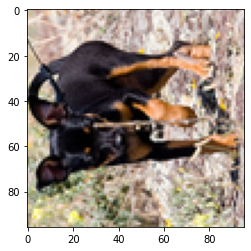

In [28]:
plot_image(x[6])

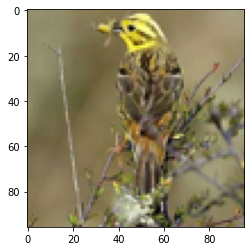

In [29]:
DATA_PATH = './root/stl10_binary/train_X.bin'
images = read_data(DATA_PATH)
t = images[0]
plot_image(t)

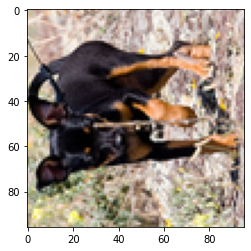

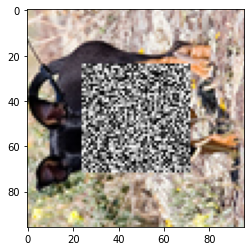

x[6].shape: torch.Size([1, 3, 96, 96])


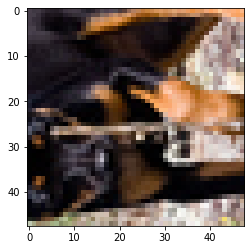

In [84]:
# Method to create the mask matrix to crop the images however we want
class DataManipulator:
    def __init__(self, image_size=(96,96), crop_center=(48,48), crop_size=(48,48)):
        self.image_size = image_size
        self.crop_center = crop_center
        self.crop_size = crop_size

        # Create masks to crop the images and calculate the loss

        self.crop_mask = torch.ones(image_size)
        self.loss_mask = torch.zeros(image_size)

        self.x1 = self.crop_center[0]-int(self.crop_size[0]/2)
        self.x2 = self.crop_center[0]+int(self.crop_size[0]/2)

        self.y1 = self.crop_center[1]-int(self.crop_size[1]/2)
        self.y2 = self.crop_center[1]+int(self.crop_size[1]/2)
        self.crop_mask[self.x1:self.x2, self.y1:self.y2] = 0
        self.loss_mask[self.x1:self.x2, self.y1:self.y2] = 1

        self.crop_mask = self.crop_mask.expand(3,-1,-1)
        self.loss_mask = self.loss_mask.expand(3,-1,-1)

    def mask_image(self, image):

        # Add noise to the cropped part
        for i in range(self.x1,self.x2):
            for j in range(self.y1,self.y2):
                self.loss_mask[:,i,j] = np.random.rand()
        
        return torch.mul(image, self.crop_mask).add(self.loss_mask)
    
    def crop_image(self, image):
        # Crops the image according to the loss_mask
        return image[:, :, self.x1:self.x2, self.y1:self.y2]
        

data_man = DataManipulator()
plot_image(x[6:7][0]) # 6:7 is for getting a batch size of 1, without losing the first dimension
plot_image(data_man.mask_image(x[6:7])[0])
print('x[6].shape: {}'.format(x[6:7].shape))
# data_man.crop_image(x[6])
plot_image(data_man.crop_image(x[6:7])[0])
# plot_image(data_man.crop_image(x[6]))

In [88]:
# TODO: Parametrize these values inside the Generator and Discriminator classes?? 
NC = 3 # Number of channels
NEF = 64 # Number of encoder filters in the first conv layer - TODO: maybe change? 
NDF = 64 # Size of the decoder filters
NDIF = 64 # Size of the discriminator filters
BTLS = 4000 # Bottleneck size - Size of the flattened feature map in the middle of encoders and decoders TODO: Make sure this is okay
NGPU = 2 # NOTE: Take a look at this, not sure if this is okay or not

# This class is only for debugging purposes - it is used to print the shape of the layer and added to the sequential model
class PrintLayer(nn.Module): 
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
#             PrintLayer(),
            
            nn.Conv2d(NC,NEF,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
        
            # state size: (nef) x 48 x 48
            nn.Conv2d(NEF,NEF,4,2,1, bias=False),
            nn.BatchNorm2d(NEF),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size: (nef) x 24 x 24
            nn.Conv2d(NEF,NEF*2,4,2,1, bias=False),
            nn.BatchNorm2d(NEF*2),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size: (nef*2) x 12 x 12
            nn.Conv2d(NEF*2,NEF*4,4,2,1, bias=False),
            nn.BatchNorm2d(NEF*4),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size: (nef*4) x 6 x 6
            nn.Conv2d(NEF*4,NEF*8,4,2,1, bias=False),
            nn.BatchNorm2d(NEF*8),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size: (nef*8) x 3 x 3
            nn.Conv2d(NEF*8, BTLS, 3, bias=False), # NOTE: The kernel size was 4 in the original paper since their input size was 128x128
            
#             PrintLayer(),
            
            # state size: (nBottleneck) x 1 x 1
            nn.BatchNorm2d(BTLS),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # input is Bottleneck, going into a convolution
            nn.ConvTranspose2d(BTLS, NDF * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.ReLU(True),
            
#             PrintLayer(),
            
            # state size. (ngf*8) x 3 x 3
            nn.ConvTranspose2d(NDF * 8, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.ReLU(True),
            
#             PrintLayer(),
            
            # state size. (ngf*4) x 6 x 6
            nn.ConvTranspose2d(NDF * 4, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.ReLU(True),
            
#             PrintLayer(),
            
            # state size. (ngf*2) x 12 x 12
            nn.ConvTranspose2d(NDF * 2, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.ReLU(True),
            
#             PrintLayer(),
            
            # state size. (ngf) x 24 x 24
            nn.ConvTranspose2d(NDF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 48 x 48
            
#             PrintLayer()
            
            # TODO: Right now the assumption is that the crop_size is 48x48
            # This could be modifiable for the next versions of the code
        )
        
    def forward(self, input):
#         print("Generator:")
        if isinstance(input.data, torch.cuda.FloatTensor) and NGPU > 1:
            output = nn.parallel.data_parallel(self.main, input, range(NGPU))
        else:
            output = self.main(input)
        return output


In [89]:
# Code for the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
#             PrintLayer(),
            # input is (nc) x 48 x 48 - TODO: Again, this is dependent on the crop size!!
            nn.Conv2d(NC, NDIF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size. (ndf) x 24 x 24
            nn.Conv2d(NDIF, NDIF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDIF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size. (ndf*2) x 12 x 12
            nn.Conv2d(NDIF * 2, NDIF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDIF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size. (ndf*4) x 6 x 6
            nn.Conv2d(NDIF * 4, NDIF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDIF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
#             PrintLayer(),
            
            # state size. (ndf*8) x 3 x 3
            nn.Conv2d(NDIF * 8, 1, 3, 1, 0, bias=False), # NOTE: Kernel size here was 4 but we changed it to 3 since the input size is 48
            nn.Sigmoid(),
            
#             PrintLayer()
        )

    def forward(self, input):
#         print("Discriminator:")
        if isinstance(input.data, torch.cuda.FloatTensor) and NGPU > 1:
            output = nn.parallel.data_parallel(self.main, input, range(NGPU))
        else:
            output = self.main(input)

        return output.view(-1, 1)

In [90]:
disc = Discriminator()
gen = Generator()
output = disc(gen(data_man.mask_image(x))) # Input of the discriminator is the generated cropped center
# print('output: {}'.format(output))
print()

In [ ]:
# Training class

class GANTrainer:
    def __init__(self, dataset_object, training_steps, discriminator_epochs, batch_size, learning_rate, wtl2, overlapL2Weight):
        '''
        Constructor for the training class. It initializes Discriminator and
        Generator and starts training both, according to the given data
        Args:
        - discriminator_epochs: Number k mentioned in Algorithm 1 of the official GAN paper.
        Steps to train Discriminator in each training iteration
        - plot_graphs: Parameter to show if we'd like to plot the outputs of each NN
        - plotting_interval: If plot_graphs is True, number of training steps to plot the graphs in
        '''
        self.training_steps = training_steps
        self.discriminator_epochs = discriminator_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.wtl2 = wtl2
        self.overlapL2Weight = overlapL2Weight

        self.generator = Generator()
        self.discriminator = Discriminator()

        # Set up optimizers for both discriminator and generator
        self.optimizer_gen = optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.optimizer_disc = optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        # Initialize the loss functions
        self.loss_func = nn.BCELoss() # Since log()s of D and Gs are calculated Binary Cross Entropy is a good loss for both
        
        # Get the data loader and manipulator objects
        self.dataset_object = dataset_object
        self.data_loader = torch.utils.data.DataLoader(dataset=self.dataset_object,
                                                       batch_size=self.batch_size,
                                                       shuffle=True)
        self.data_iter = iter(self.data_loader)
        self.data_man = DataManipulator()

    def train(self):
        '''
        Training function. Follows the exact same algorithm as Algorithm 1 in
        GAN paper. But there is no noisy data created - the input of the generator
        is the cropped images
        Args:
        - X: The actual data generated
        '''
        # Get the real and fake labels
        label_real = torch.full((self.batch_size,1), 1., dtype=torch.float)
        label_fake = torch.full((self.batch_size,1), 0., dtype=torch.float)
        for training_step in range(self.training_steps):
            # Train the discriminator for some set amount of discriminator epochs
            for k in range(self.discriminator_epochs):
                # Get a batch of data from the data loader
                try:
                    x_original, _ = self.data_iter.next()
                    label_real = torch.full((x_original.shape[0],1), 1., dtype=torch.float)
                    label_fake = torch.full((x_original.shape[0],1), 0., dtype=torch.float)
                except StopIteration: # If we reach the end of the dataloader - reinitialize it and continue
                    # TODO: You might wanna change how we act here - not sure if we should keep getting more data
                    self.data_loader = torch.utils.data.DataLoader(dataset=self.dataset_object,
                                                       batch_size=self.batch_size,
                                                       shuffle=True)
                    self.data_iter = iter(self.data_loader)
                    continue
                
                
                # Crop the original image and give it to discriminator as the real label
                self.discriminator.zero_grad()
                x_cropped = self.data_man.crop_image(x_original)
                output_real = self.discriminator(x_cropped)
                disc_loss_real = self.loss_func(output_real, label_real)
                disc_loss_real.backward()
        
                # Train it with the fake output
                x_masked = self.data_man.mask_image(x_original)
                output_fake = self.discriminator(self.generator(x_masked))
                disc_loss_fake = self.loss_func(output_fake, label_fake)
                disc_loss_fake.backward()
                
                disc_loss = disc_loss_real + disc_loss_fake
                self.optimizer_disc.step()

            try:
                x_original, _ = self.data_iter.next()
                label_real = torch.full((x_original.shape[0],1), 1., dtype=torch.float)
                label_fake = torch.full((x_original.shape[0],1), 0., dtype=torch.float)
            except StopIteration: # If we reach the end of the dataloader - reinitialize it and continue
                # TODO: You might wanna change how we act here - not sure if we should keep getting more data
                self.data_loader = torch.utils.data.DataLoader(dataset=self.dataset_object,
                                                   batch_size=self.batch_size,
                                                   shuffle=True)
                self.data_iter = iter(self.data_loader)
                continue
                
            # Train the generator after training the discriminator for some time
            self.generator.zero_grad()
            # Get the output of the generator for the fake data
            x_masked = self.data_man.mask_image(x_original)
            output_gen = self.generator(x_masked)
            # Get the output of the data generated from generator, from discriminator
            output_disc_gen = self.discriminator(output_gen)
            # Discriminator should think the output of generator is real
            # so the loss is calculated bw output of disc and real label (1.)
            gen_loss_disc = self.loss_func(output_disc_gen, label_real)

            # Calculate the second loss function (l2) -- TODO: Completedly understand this...
            x_cropped = self.data_man.crop_image(x_original)
            wtl2Matrix = x_cropped.clone()
            wtl2Matrix.data.fill_(self.wtl2 * self.overlapL2Weight) # 10 * 0.998
            # TODO: CHANGE THIS!!!
            wtl2Matrix.data[:,:,24:72,24:72] = self.wtl2
#             wtl2Matrix.data[:,:,int(opt.overlapPred):int(opt.imageSize/2 - opt.overlapPred),int(opt.overlapPred):int(opt.imageSize/2 - opt.overlapPred)] = wtl2

            gen_loss_l2 = (output_gen-x_cropped).pow(2)
            gen_loss_l2 = gen_loss_l2 * wtl2Matrix
            gen_loss_l2 = gen_loss_l2.mean()
            
            gen_loss = (1-self.wtl2) * gen_loss_disc + self.wtl2 * gen_loss_l2
            gen_loss.backward()
            self.optimizer_gen.step()
            
            if training_step % 20 == 0: # Print the losses
                print('| {} | GEN_LOSS: {} | DISC_LOSS: {} |'.format(
                    training_step, gen_loss, disc_loss
                ))
                
                torch.save(self.generator.state_dict(), 'model_gen_{}.pth'.format(training_step))
                
# data_man = DataManipulator()
trainer = GANTrainer(
    dataset_object=dataset_object,
#     data_manipulator=data_man,
    training_steps=1000,
    discriminator_epochs=3,
    batch_size=128,
    learning_rate=0.01, # TODO: test different learning rates for generator and discriminator
    wtl2=0.998,
    overlapL2Weight=5
)
trainer.train()

| 0 | GEN_LOSS: 2.289151668548584 | DISC_LOSS: 3.8602280616760254 |
| 20 | GEN_LOSS: 0.3266664743423462 | DISC_LOSS: 0.00019644641724880785 |


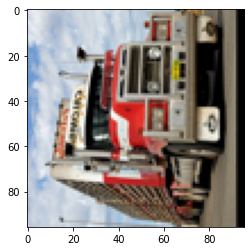

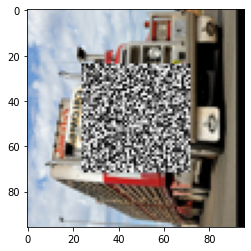

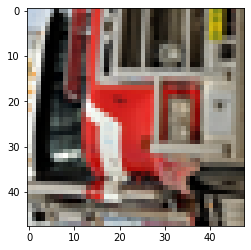

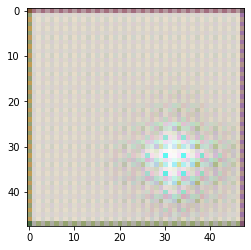

In [87]:
# The function to load the generator and get a sample output of an image
def get_output(x): # x is an image
    model = Generator()
    model.load_state_dict(torch.load('model_gen_20.pth'))  # Choose whatever GPU device number you want
    plot_image(x[0])
#     print('data_man.loss_mask: {}'.format(data_man.loss_mask))
    
    plot_image(data_man.mask_image(x)[0])
    gen_output = model(data_man.mask_image(x))
    plot_image(data_man.crop_image(x)[0])
#     print('gen_output')
    plot_image(gen_output.detach().numpy()[0])
    
#     print(data_man.crop_image(x)[0])
#     print(gen_output[0])
#     print(gen_output.detach().numpy()[0])
    
get_output(x[7:9])

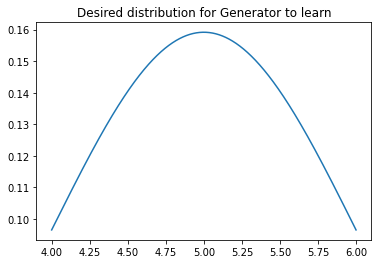

In [ ]:
# Cells to implement simple GAN to learn a set Gaussian distribution

import numpy as np
import math
import matplotlib.pyplot as plt
# import scipy.stats as stats

def gaussian(x, mean, std):
    assert len(x.shape) == 1 # X should be a 1D array
    y = np.zeros(x.shape)
    for i in range(len(x)):
        y[i] = (1.0/(std*2*math.pi)) * math.exp((-1.0/2.0)*((x[i]-mean)/std)**2)  
    return y

# Create the distribution to learn 
mean = 5
std = 1
x = np.linspace(mean-std, mean+std, 5000)
plt.plot(x, gaussian(x, mean, std))
plt.title("Desired distribution for Generator to learn")
plt.show()

In [ ]:
# Classes for Generator and Distributor (They are totally experimental and
# probably not even close to being last versions :D)
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_layers=[]):
        '''
        Constructor for the Generator module of the GAN.
        Input of the Generator will be real-time float and the output will be
        the mapped version of that input, such that the mapped version will be a
        part of the distribution that we are trying to imitate
        Args:
        - hidden_layers: Array of dimensions for each hidden layer
        - input/output_size: Dimensions of input and output data
        '''
        super(Generator, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers

        # Create the layers (for now they are linear layers -- convolutional
        # layers might be added as time passes)
        layers_array = []
        for i in range(len(hidden_layers)+1):
            if i == 0:
                if len(self.hidden_layers) > 0: # If there are supposed to be any hidden layers
                    layers_array.append(
                        nn.Linear(self.input_size, self.hidden_layers[i])
                    )
                    layers_array.append(nn.Sigmoid())
                else: # If not just add one layer from input to output
                    layers_array.append(
                        nn.Linear(self.input_size, self.output_size)
                    )
            elif i == len(hidden_layers):
                layers_array.append(
                    nn.Linear(self.hidden_layers[i-1], self.output_size)
                )
            else:
                layers_array.append(
                    nn.Linear(self.hidden_layers[i-1], self.hidden_layers[i])
                )
                layers_array.append(nn.Sigmoid())
            # layers_array.append(nn.Sigmoid())
            # TODO: I didn't add Sigmoid to the end layer of the Generator
            # this decision should be checked though

        self.layers = nn.ModuleList(layers_array)

    def forward(self, x): # Method for forward propagation
        for layer in self.layers:
            x = layer(x)
        return x

# For now, both of these methods are 
class Discriminator(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_layers=[]):
        '''
        Constructor for the Discriminator module of the GAN.
        Input of discriminator will be a real number x and output will be the
        propability of that x being extracted from an actual data
        (p_data/(p_data+p_g) --> refer to the GAN paper)
        Args:
        - hidden_layers: Array of dimensions for each hidden layer
        - input/output_size: Dimensions of input and output data
        '''
        super(Discriminator, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers

        # Create the layers (for now they are linear layers -- convolutional
        # layers might be added as time passes)
        layers_array = []
        for i in range(len(hidden_layers)+1):
            if i == 0:
                if len(self.hidden_layers) > 0: # If there are supposed to be any hidden layers
                    layers_array.append(
                        nn.Linear(self.input_size, self.hidden_layers[i])
                    )
                else: # If not just add one layer from input to output
                    layers_array.append(
                        nn.Linear(self.input_size, self.output_size)
                    )
            elif i == len(hidden_layers):
                layers_array.append(
                    nn.Linear(self.hidden_layers[i-1], self.output_size)
                )
            else:
                layers_array.append(
                    nn.Linear(self.hidden_layers[i-1], self.hidden_layers[i])
                )
            layers_array.append(nn.Sigmoid())

        self.layers = nn.ModuleList(layers_array)

    def forward(self, x): # Method for forward propagation
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
import torch.optim as optim

# Implement the Training class for the GAN
class GANTrainer:
    def __init__(self, training_steps, discriminator_epochs, batch_size, learning_rate, plot_graphs=False, plotting_interval=None):
        '''
        Constructor for the training class. It initializes Discriminator and
        Generator and starts training both, according to the given data
        Args:
        - discriminator_epochs: Number k mentioned in Algorithm 1 of the official GAN paper.
        Steps to train Discriminator in each training iteration
        - plot_graphs: Parameter to show if we'd like to plot the outputs of each NN
        - plotting_interval: If plot_graphs is True, number of training steps to plot the graphs in
        '''
        self.training_steps = training_steps
        self.discriminator_epochs = discriminator_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.plot_graphs = plot_graphs
        self.plotting_interval = plotting_interval


        self.generator = Generator(1, 1, [])
        self.discriminator = Discriminator(1, 1, [])
        print('self.generator: {}'.format(self.generator))
        print('self.discriminator: {}'.format(self.discriminator))

        # Set up optimizers for both discriminator and generator
        self.optimizer_generator = optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.optimizer_discriminator = optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        # Initialize the loss functions
        self.loss_func = nn.BCELoss() # Since log()s of D and Gs are calculated Binary Cross Entropy is a good loss for both

    def train(self, X):
        '''
        Training function. Follows the exact same algorithm as Algorithm 1 in
        GAN paper.
        Creates a mock data - noise (p_z) - in each batch to learn to map to X
        Args:
        - X: The actual data generated
        '''
        # Get the real and fake labels
        label_real = torch.full((self.batch_size,1), 1., dtype=torch.float)
        label_fake = torch.full((self.batch_size,1), 0., dtype=torch.float)
        for training_step in range(self.training_steps):
            for k in range(self.discriminator_epochs):
                # Sample batch from X and create noisy batch z
                x_indices = np.random.randint(X.shape[0], size=(self.batch_size,1))
                x_batch = torch.tensor(X[x_indices]).type(torch.FloatTensor)
                z_batch = torch.randn(self.batch_size, 1) # Noisy data created is between 0 to 1 -- TODO: this should be checked as well
                # z_batch = np.random.rand(self.batch_size) 

                # Train the discriminator. In DCGAN tutorial of pytorch they did
                # two rounds of backward propagation one for log(D(x)) and for
                # log(1-D(G(z)))
                self.discriminator.zero_grad()
                # Forward pass real batch through discriminator (D(x))
                disc_output_real = self.discriminator(x_batch)
                # Calculate the loss log(D(x))
                disc_loss_real = self.loss_func(disc_output_real, label_real)
                disc_loss_real.backward()

                # Train the discriminator with the fake batch
                disc_output_fake = self.discriminator(z_batch)
                disc_loss_fake = self.loss_func(disc_output_fake, label_fake)
                disc_loss_fake.backward()
                disc_loss = disc_loss_real + disc_loss_fake # To be used in plotting

                self.optimizer_discriminator.step() # Update the discriminator
            
            # Train the generator after training the discriminator for some time
            self.generator.zero_grad()
            # Get the output of the generator for the fake data
            gen_output_fake = self.generator(z_batch)
            # Get the output of the data generated from generator, from discriminator
            disc_output_gen = self.discriminator(gen_output_fake)
            # Discriminator should think the output of generator is real
            # so the loss is calculated bw output of disc and real label (1.)
            gen_loss = self.loss_func(disc_output_gen, label_real)
            gen_loss.backward()

            self.optimizer_generator.step()

            if training_step % 20 == 0: # Print the losses
                print('{}, gen_loss: {}, disc_loss: {}'.format(
                    training_step, gen_loss, disc_loss
                ))

            # Plotting the distribution of the actual data and the output of the generator
            if self.plot_graphs and training_step % self.plotting_interval == 0:
                self.plot_distributions(x_batch, gen_output_fake)

    def plot_distributions(self, x_batch, gen_output):
        # Calculate mean and std of both x_batch and gen_output
        mean_x, mean_out = torch.mean(x_batch), torch.mean(gen_output)
        std_x, std_out = torch.std(x_batch), torch.std(gen_output)

        # Plot the distributions
        plt.plot(x_batch, gaussian(x_batch.view(-1), mean_x, std_x), 'ob', label="Real Data")
        plt.plot(gen_output.detach().numpy(), gaussian(gen_output.view(-1).detach().numpy(), mean_out, std_out), 'og', label="Output of Generator")
        # plt.title("Desired distribution for Generator to learn")
        plt.legend()
        plt.show()




self.generator: Generator(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)
self.discriminator: Discriminator(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
0, gen_loss: 0.9614028930664062, disc_loss: 0.6975077986717224


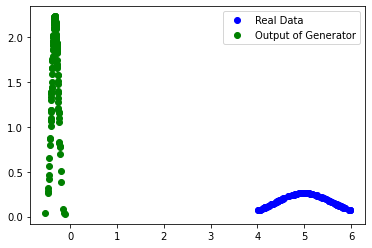

20, gen_loss: 2.0091168880462646, disc_loss: 0.2699468731880188
40, gen_loss: 2.638009548187256, disc_loss: 0.16321063041687012
60, gen_loss: 2.926849603652954, disc_loss: 0.09882515668869019
80, gen_loss: 3.014683485031128, disc_loss: 0.08695780485868454
100, gen_loss: 2.9493119716644287, disc_loss: 0.05911462754011154


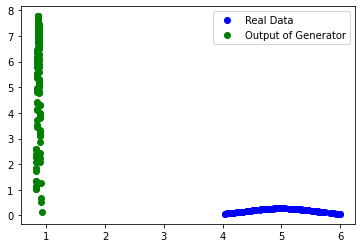

120, gen_loss: 2.797459125518799, disc_loss: 0.06914667040109634
140, gen_loss: 2.5807385444641113, disc_loss: 0.04613913595676422
160, gen_loss: 2.2680773735046387, disc_loss: 0.036074262112379074
180, gen_loss: 1.8620483875274658, disc_loss: 0.02855629473924637
200, gen_loss: 1.6208693981170654, disc_loss: 0.02048330381512642


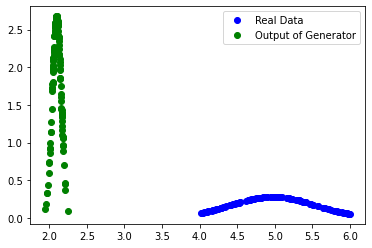

220, gen_loss: 1.1969563961029053, disc_loss: 0.022010933607816696
240, gen_loss: 0.919843316078186, disc_loss: 0.02755490131676197
260, gen_loss: 0.661334753036499, disc_loss: 0.03535778075456619
280, gen_loss: 0.5075392127037048, disc_loss: 0.009048543870449066
300, gen_loss: 0.421471506357193, disc_loss: 0.015555378049612045


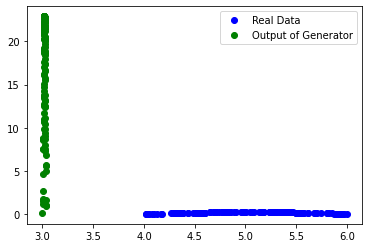

320, gen_loss: 0.30167558789253235, disc_loss: 0.016800656914711
340, gen_loss: 0.22253991663455963, disc_loss: 0.009410955011844635
360, gen_loss: 0.17984259128570557, disc_loss: 0.025499287992715836
380, gen_loss: 0.1550864279270172, disc_loss: 0.005132752470672131
400, gen_loss: 0.13602347671985626, disc_loss: 0.010813498869538307


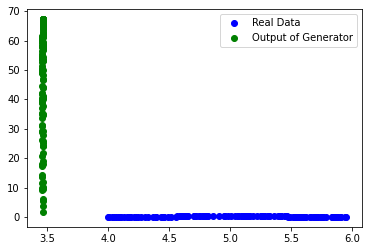

420, gen_loss: 0.11552503705024719, disc_loss: 0.007412400096654892
440, gen_loss: 0.08447957038879395, disc_loss: 0.009590072557330132
460, gen_loss: 0.08146741986274719, disc_loss: 0.004573623184114695
480, gen_loss: 0.06304989010095596, disc_loss: 0.004049142822623253
500, gen_loss: 0.05521952360868454, disc_loss: 0.00396640133112669


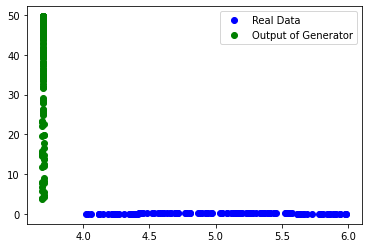

520, gen_loss: 0.055790673941373825, disc_loss: 0.005341550800949335
540, gen_loss: 0.04888531193137169, disc_loss: 0.0036317938938736916
560, gen_loss: 0.04170186072587967, disc_loss: 0.003494267351925373
580, gen_loss: 0.040520910173654556, disc_loss: 0.017690248787403107
600, gen_loss: 0.03687332198023796, disc_loss: 0.004524313844740391


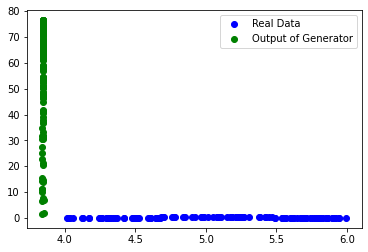

620, gen_loss: 0.025268301367759705, disc_loss: 0.00624472089111805
640, gen_loss: 0.023220892995595932, disc_loss: 0.004077857360243797
660, gen_loss: 0.02234102599322796, disc_loss: 0.0028655596543103456
680, gen_loss: 0.022887155413627625, disc_loss: 0.003702848684042692
700, gen_loss: 0.0232231505215168, disc_loss: 0.004243356175720692


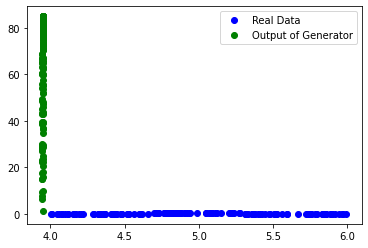

720, gen_loss: 0.01582532562315464, disc_loss: 0.002002248540520668
740, gen_loss: 0.013948016799986362, disc_loss: 0.0013609188608825207
760, gen_loss: 0.01928711123764515, disc_loss: 0.0033047539182007313
780, gen_loss: 0.015939923003315926, disc_loss: 0.008577102795243263
800, gen_loss: 0.013811181299388409, disc_loss: 0.0021203181240707636


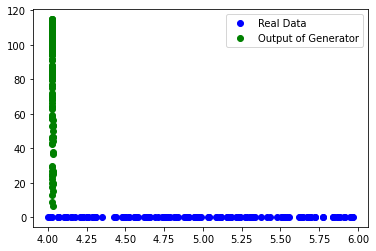

820, gen_loss: 0.008953935466706753, disc_loss: 0.003467005677521229
840, gen_loss: 0.009010469540953636, disc_loss: 0.0035400036722421646
860, gen_loss: 0.010824989527463913, disc_loss: 0.001840283046476543
880, gen_loss: 0.008686963468790054, disc_loss: 0.0031718825921416283
900, gen_loss: 0.005913527216762304, disc_loss: 0.011281166225671768


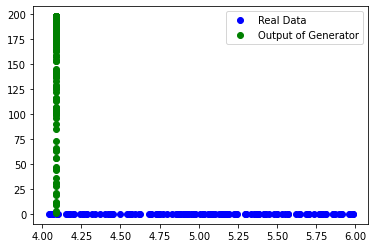

920, gen_loss: 0.007922393269836903, disc_loss: 0.008005435578525066
940, gen_loss: 0.008444737643003464, disc_loss: 0.0012768706073984504
960, gen_loss: 0.006626697722822428, disc_loss: 0.001328416052274406
980, gen_loss: 0.005144620314240456, disc_loss: 0.016208741813898087
1000, gen_loss: 0.00488264299929142, disc_loss: 0.0010496198665350676


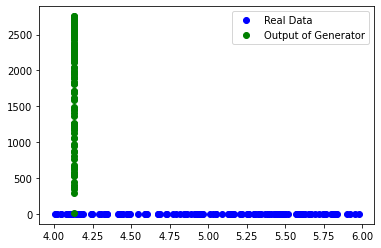

1020, gen_loss: 0.0058564674109220505, disc_loss: 0.001235313480719924
1040, gen_loss: 0.004753943532705307, disc_loss: 0.0009101010509766638
1060, gen_loss: 0.004395078867673874, disc_loss: 0.0025557822082191706
1080, gen_loss: 0.00537812290713191, disc_loss: 0.0073745050467550755
1100, gen_loss: 0.004368363879621029, disc_loss: 0.0015022000297904015


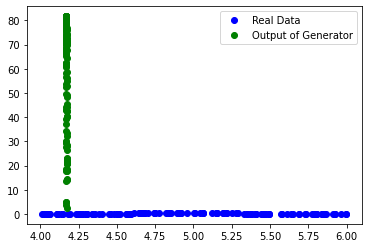

1120, gen_loss: 0.0038689589127898216, disc_loss: 0.0011574230156838894
1140, gen_loss: 0.0032105271238833666, disc_loss: 0.0009499478037469089
1160, gen_loss: 0.0037098403554409742, disc_loss: 0.006264947820454836
1180, gen_loss: 0.0024781993124634027, disc_loss: 0.0008915493963286281
1200, gen_loss: 0.0035979668609797955, disc_loss: 0.0013788811629638076


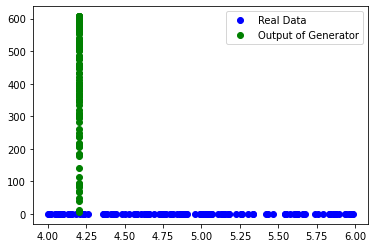

1220, gen_loss: 0.0032007857225835323, disc_loss: 0.0013903111685067415
1240, gen_loss: 0.0023083738051354885, disc_loss: 0.0007157809450291097
1260, gen_loss: 0.002962785540148616, disc_loss: 0.0007203271961770952
1280, gen_loss: 0.001983736641705036, disc_loss: 0.0006284865085035563
1300, gen_loss: 0.003149589290842414, disc_loss: 0.0014187055639922619


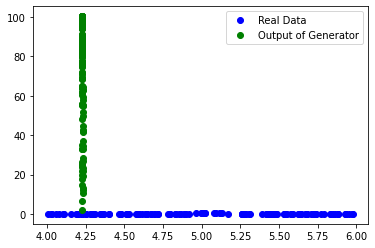

1320, gen_loss: 0.0020507932640612125, disc_loss: 0.001617642119526863
1340, gen_loss: 0.0011548183392733335, disc_loss: 0.00044757226714864373
1360, gen_loss: 0.0021914236713200808, disc_loss: 0.0008916204678826034
1380, gen_loss: 0.001221159822307527, disc_loss: 0.0007114282925613225
1400, gen_loss: 0.001626008888706565, disc_loss: 0.000866142101585865


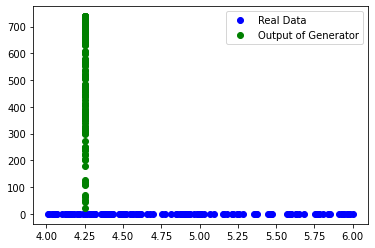

1420, gen_loss: 0.0026843242812901735, disc_loss: 0.0012081649620085955
1440, gen_loss: 0.0015042602317407727, disc_loss: 0.000725842546671629
1460, gen_loss: 0.0022277142852544785, disc_loss: 0.001079679001122713
1480, gen_loss: 0.001220106496475637, disc_loss: 0.0006337638478726149
1500, gen_loss: 0.0014302247436717153, disc_loss: 0.0012584226205945015


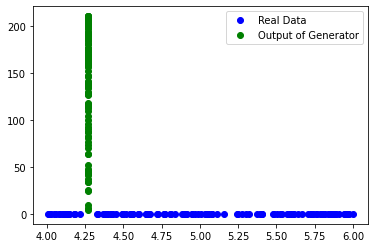

1520, gen_loss: 0.001058225054293871, disc_loss: 0.0005057876696810126
1540, gen_loss: 0.0011172899976372719, disc_loss: 0.0007150396122597158
1560, gen_loss: 0.0009649654384702444, disc_loss: 0.0007027557585388422
1580, gen_loss: 0.0014647284988313913, disc_loss: 0.0006405928288586438
1600, gen_loss: 0.0014236343558877707, disc_loss: 0.00100614782422781


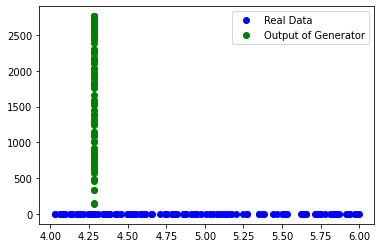

1620, gen_loss: 0.0008549619233235717, disc_loss: 0.0023775333538651466
1640, gen_loss: 0.0010748710483312607, disc_loss: 0.0004676592943724245
1660, gen_loss: 0.001245901919901371, disc_loss: 0.0009310274617746472
1680, gen_loss: 0.0011594821698963642, disc_loss: 0.000714867957867682
1700, gen_loss: 0.0009165788069367409, disc_loss: 0.0006556719308719039


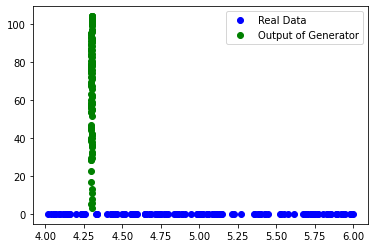

1720, gen_loss: 0.0009885655017569661, disc_loss: 0.0007143875118345022
1740, gen_loss: 0.0007496962207369506, disc_loss: 0.0005703617352992296
1760, gen_loss: 0.0007768216892145574, disc_loss: 0.0004079618083778769
1780, gen_loss: 0.0009315286297351122, disc_loss: 0.0014160614227876067
1800, gen_loss: 0.0011316273594275117, disc_loss: 0.0007536222692579031


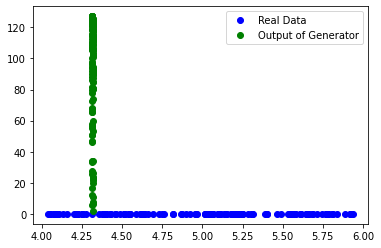

1820, gen_loss: 0.0009396428940817714, disc_loss: 0.0009673142922110856
1840, gen_loss: 0.0005711052799597383, disc_loss: 0.0006129746907390654
1860, gen_loss: 0.0006672143936157227, disc_loss: 0.00043373610242269933
1880, gen_loss: 0.0010502394288778305, disc_loss: 0.0012178139295428991
1900, gen_loss: 0.0005942239076830447, disc_loss: 0.0005663642659783363


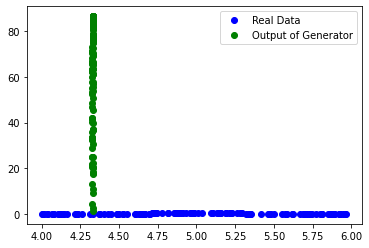

1920, gen_loss: 0.0007460860069841146, disc_loss: 0.0007681139395572245
1940, gen_loss: 0.0005121332360431552, disc_loss: 0.0005239557358436286
1960, gen_loss: 0.0004709335626102984, disc_loss: 0.0005077984533272684
1980, gen_loss: 0.0005282450583763421, disc_loss: 0.0005169979995116591
2000, gen_loss: 0.0003568757383618504, disc_loss: 0.00034128810511901975


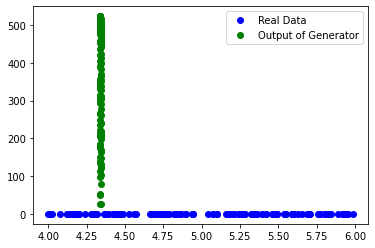

2020, gen_loss: 0.0003993861610069871, disc_loss: 0.0007600831449963152
2040, gen_loss: 0.0008336211903952062, disc_loss: 0.0008605612674728036
2060, gen_loss: 0.00068859156453982, disc_loss: 0.0006309366435743868
2080, gen_loss: 0.0004332631069701165, disc_loss: 0.0004810107930097729
2100, gen_loss: 0.00034371521905995905, disc_loss: 0.000279101834166795


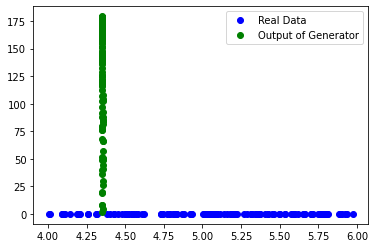

2120, gen_loss: 0.0004553691251203418, disc_loss: 0.000348138710251078
2140, gen_loss: 0.0005291171837598085, disc_loss: 0.0005163864698261023
2160, gen_loss: 0.0004923149244859815, disc_loss: 0.00044514983892440796
2180, gen_loss: 0.0004040120402351022, disc_loss: 0.0037227373104542494
2200, gen_loss: 0.00045173108810558915, disc_loss: 0.0006198289920575917


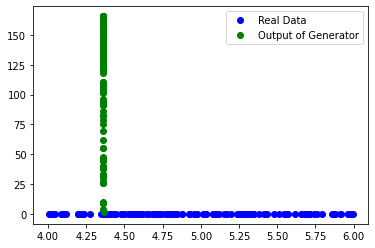

2220, gen_loss: 0.0002944274165201932, disc_loss: 0.0010274534579366446
2240, gen_loss: 0.00044619187247008085, disc_loss: 0.00048478151438757777
2260, gen_loss: 0.0003614762390498072, disc_loss: 0.0068374560214579105
2280, gen_loss: 0.0003810664056800306, disc_loss: 0.0024567004293203354
2300, gen_loss: 0.0003056089917663485, disc_loss: 0.000633900286629796


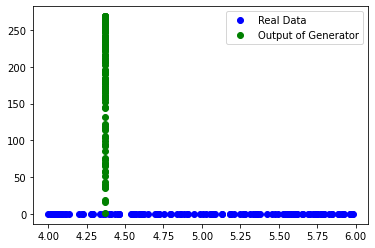

2320, gen_loss: 0.0005421421956270933, disc_loss: 0.000458427268313244
2340, gen_loss: 0.0005257724551483989, disc_loss: 0.000608219241257757
2360, gen_loss: 0.00031202592072077096, disc_loss: 0.0006841999711468816
2380, gen_loss: 0.00037335214437916875, disc_loss: 0.0005964867305010557
2400, gen_loss: 0.00029044528491795063, disc_loss: 0.00063955137738958


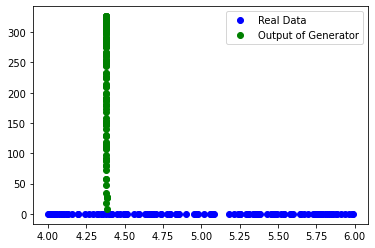

2420, gen_loss: 0.0003084904165007174, disc_loss: 0.019345687702298164
2440, gen_loss: 0.0003002462035510689, disc_loss: 0.0004408491950016469
2460, gen_loss: 0.0002924165746662766, disc_loss: 0.0006061484455130994
2480, gen_loss: 0.00024411827325820923, disc_loss: 0.00041617132956162095
2500, gen_loss: 0.00020942887931596488, disc_loss: 0.00024578714510425925


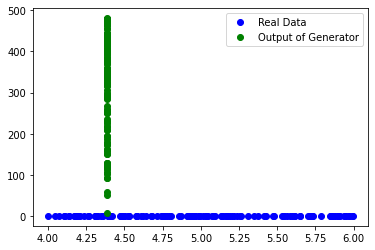

2520, gen_loss: 0.00028247368754819036, disc_loss: 0.0005593211972154677
2540, gen_loss: 0.00024003436556085944, disc_loss: 0.0004733077948912978
2560, gen_loss: 0.0002633689437061548, disc_loss: 0.0004219495167490095
2580, gen_loss: 0.000191820552572608, disc_loss: 0.0002330526040168479
2600, gen_loss: 0.00044281058944761753, disc_loss: 0.000772348081227392


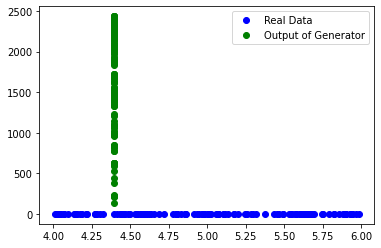

2620, gen_loss: 0.000319654936902225, disc_loss: 0.0004269394266884774
2640, gen_loss: 0.0003367801255080849, disc_loss: 0.0006296784267760813
2660, gen_loss: 0.00037297108792699873, disc_loss: 0.0008608188945800066
2680, gen_loss: 0.0002879085950553417, disc_loss: 0.0004318191495258361
2700, gen_loss: 0.00024893812951631844, disc_loss: 0.0005159482825547457


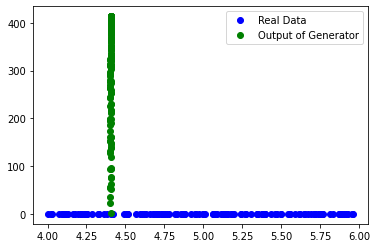

2720, gen_loss: 0.00019335566321387887, disc_loss: 0.00031612624297849834
2740, gen_loss: 0.00022642084513790905, disc_loss: 0.0003596848691813648
2760, gen_loss: 0.0001856801100075245, disc_loss: 0.0034522900823503733
2780, gen_loss: 0.0002334697637706995, disc_loss: 0.0004927734844386578
2800, gen_loss: 0.00019021744083147496, disc_loss: 0.014649800024926662


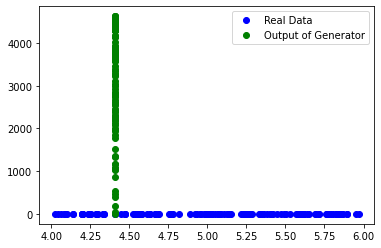

2820, gen_loss: 0.0001764732733136043, disc_loss: 0.00028303146245889366
2840, gen_loss: 0.00017142553406301886, disc_loss: 0.0003243414394091815
2860, gen_loss: 0.000289942225208506, disc_loss: 0.0005502654821611941
2880, gen_loss: 0.00013299891725182533, disc_loss: 0.00018808763707056642
2900, gen_loss: 0.0002071802009595558, disc_loss: 0.00031114398734644055


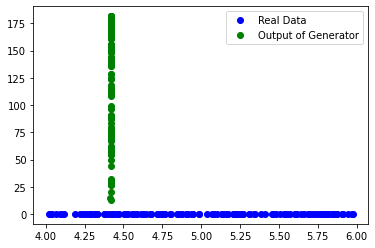

2920, gen_loss: 0.00020128187316004187, disc_loss: 0.00047679292038083076
2940, gen_loss: 0.00018908007768914104, disc_loss: 0.00027370874886401
2960, gen_loss: 0.00023282141773961484, disc_loss: 0.0003171800053678453
2980, gen_loss: 0.00018111579993274063, disc_loss: 0.0005897107184864581
3000, gen_loss: 0.00020006623526569456, disc_loss: 0.00042040066909976304


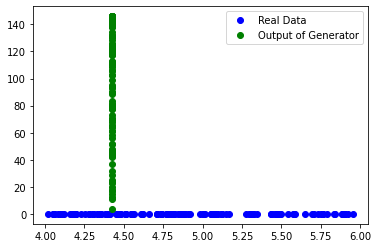

3020, gen_loss: 0.0001540898811072111, disc_loss: 0.0039029866456985474
3040, gen_loss: 0.00041685375617817044, disc_loss: 0.0013428619131445885
3060, gen_loss: 0.00010271059727529064, disc_loss: 0.0003895533736795187
3080, gen_loss: 0.00019535748288035393, disc_loss: 0.0004035021993331611
3100, gen_loss: 0.00012317685468588024, disc_loss: 0.0002853175683412701


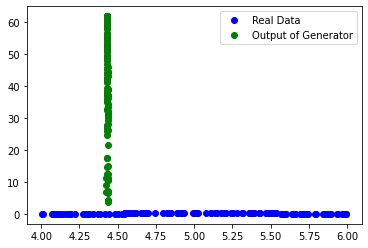

3120, gen_loss: 9.397671965416521e-05, disc_loss: 0.00022461572370957583
3140, gen_loss: 8.271884144051e-05, disc_loss: 0.00047562591498717666
3160, gen_loss: 9.085744386538863e-05, disc_loss: 0.00015440740389749408
3180, gen_loss: 9.950560342986137e-05, disc_loss: 0.0004895009333267808
3200, gen_loss: 0.00014828500570729375, disc_loss: 0.0005005752900615335


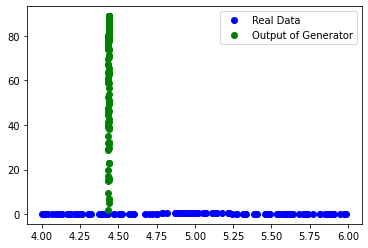

3220, gen_loss: 0.000162011114298366, disc_loss: 0.0003588116669561714
3240, gen_loss: 0.0001380846370011568, disc_loss: 0.0003642653173301369
3260, gen_loss: 0.00010464980732649565, disc_loss: 0.00023569756012875587
3280, gen_loss: 7.777870632708073e-05, disc_loss: 0.00018309737788513303
3300, gen_loss: 0.00013262633001431823, disc_loss: 0.01637602038681507


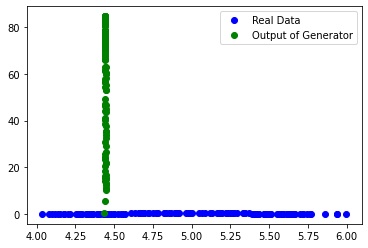

3320, gen_loss: 0.00011975941743003204, disc_loss: 0.0004049211856909096
3340, gen_loss: 8.279987378045917e-05, disc_loss: 0.0002626912610139698
3360, gen_loss: 0.00016891008999664336, disc_loss: 0.000486046657897532
3380, gen_loss: 9.465758921578526e-05, disc_loss: 0.0002529558551032096
3400, gen_loss: 8.408613211940974e-05, disc_loss: 0.0004408121749293059


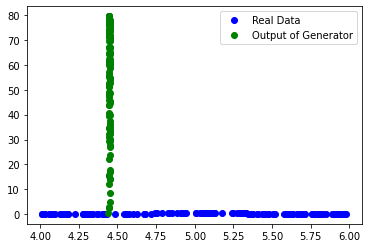

3420, gen_loss: 0.00011349740816513076, disc_loss: 0.00043244240805506706
3440, gen_loss: 0.00012790765322279185, disc_loss: 0.00027471495559439063
3460, gen_loss: 9.036565461428836e-05, disc_loss: 0.00024345838755834848
3480, gen_loss: 5.280086770653725e-05, disc_loss: 0.0010614932980388403
3500, gen_loss: 8.113359217531979e-05, disc_loss: 0.0003986462252214551


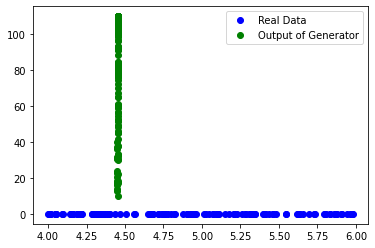

3520, gen_loss: 0.0001060674330801703, disc_loss: 0.0001854440924944356
3540, gen_loss: 8.64910107338801e-05, disc_loss: 0.00021466777252499014
3560, gen_loss: 6.480539013864473e-05, disc_loss: 0.00020391630823723972
3580, gen_loss: 8.788997365627438e-05, disc_loss: 0.00018133399134967476
3600, gen_loss: 6.316987128229812e-05, disc_loss: 0.00019805290503427386


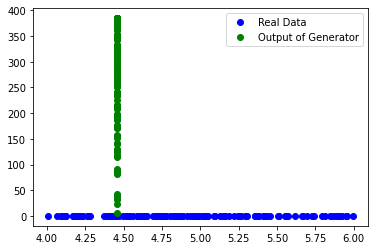

3620, gen_loss: 6.433224189095199e-05, disc_loss: 0.0015014780219644308
3640, gen_loss: 7.527325942646712e-05, disc_loss: 0.0002786301192827523
3660, gen_loss: 6.825057789683342e-05, disc_loss: 0.0003516211290843785
3680, gen_loss: 7.28916929801926e-05, disc_loss: 0.00040472677210345864
3700, gen_loss: 8.921629341784865e-05, disc_loss: 0.00024448090698570013


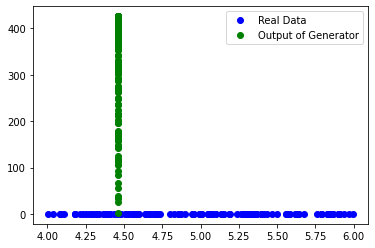

3720, gen_loss: 9.974309796234593e-05, disc_loss: 0.00015288012218661606
3740, gen_loss: 7.839994941605255e-05, disc_loss: 0.00022925360826775432
3760, gen_loss: 7.176656072260812e-05, disc_loss: 0.0002944436273537576
3780, gen_loss: 9.993777348427102e-05, disc_loss: 0.0005251789698377252
3800, gen_loss: 8.36725885164924e-05, disc_loss: 0.00037662952672690153


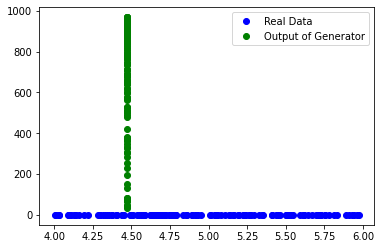

3820, gen_loss: 6.409008346963674e-05, disc_loss: 0.0004181317053735256
3840, gen_loss: 8.859877561917529e-05, disc_loss: 0.00048768785200081766
3860, gen_loss: 6.711802416248247e-05, disc_loss: 0.0002974526723846793
3880, gen_loss: 5.615752888843417e-05, disc_loss: 0.00028306152671575546
3900, gen_loss: 7.274638483067974e-05, disc_loss: 0.0003975778236053884


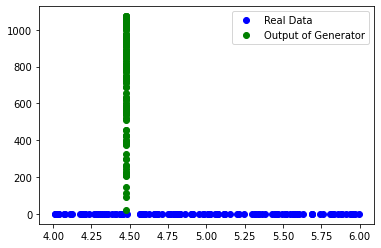

3920, gen_loss: 8.230435923906043e-05, disc_loss: 0.00041477347258478403
3940, gen_loss: 4.8857444198802114e-05, disc_loss: 0.0002765135432127863
3960, gen_loss: 6.188085535541177e-05, disc_loss: 0.0003042753378394991
3980, gen_loss: 8.167939085979015e-05, disc_loss: 0.0002241055335616693
4000, gen_loss: 5.018091542297043e-05, disc_loss: 0.0002632555551826954


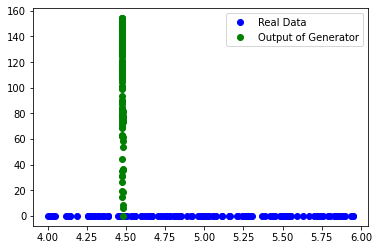

4020, gen_loss: 5.048920138506219e-05, disc_loss: 0.0001490473368903622
4040, gen_loss: 4.37936105299741e-05, disc_loss: 0.00018678043852560222
4060, gen_loss: 6.201962241902947e-05, disc_loss: 0.0002203225449193269
4080, gen_loss: 9.837951074587181e-05, disc_loss: 0.00045951566426083446
4100, gen_loss: 7.30062456568703e-05, disc_loss: 0.0002313143340870738


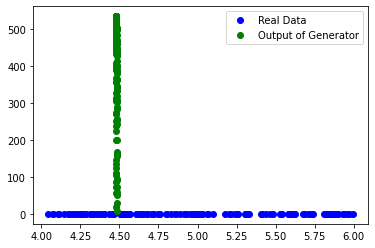

4120, gen_loss: 6.40463040326722e-05, disc_loss: 0.0003567099629435688
4140, gen_loss: 6.200006464496255e-05, disc_loss: 0.0015372313791885972
4160, gen_loss: 4.6659421059302986e-05, disc_loss: 0.0002708874817471951
4180, gen_loss: 7.040301716187969e-05, disc_loss: 0.00039146526250988245
4200, gen_loss: 5.40898836334236e-05, disc_loss: 0.00025424879277125


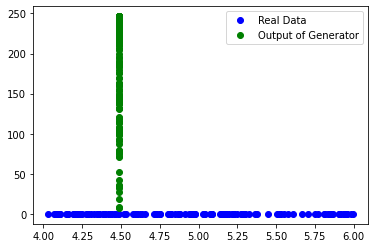

4220, gen_loss: 6.063745604478754e-05, disc_loss: 0.00035599383409135044
4240, gen_loss: 7.321021985262632e-05, disc_loss: 0.0004365653730928898
4260, gen_loss: 4.7466917749261484e-05, disc_loss: 0.0002963088627438992
4280, gen_loss: 3.575411392375827e-05, disc_loss: 0.00024776096688583493
4300, gen_loss: 6.712733011227101e-05, disc_loss: 0.0004451868589967489


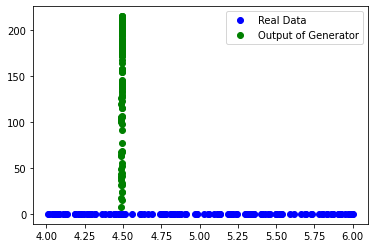

4320, gen_loss: 5.2006398618686944e-05, disc_loss: 0.00040563964284956455
4340, gen_loss: 4.1318977309856564e-05, disc_loss: 0.00017422369273845106
4360, gen_loss: 4.501742296270095e-05, disc_loss: 0.0002337403129786253
4380, gen_loss: 4.832097329199314e-05, disc_loss: 0.00022601416276302189
4400, gen_loss: 4.254558007232845e-05, disc_loss: 0.00024515585391782224


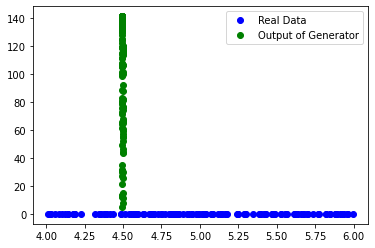

4420, gen_loss: 5.5432927183574066e-05, disc_loss: 0.00033066628384403884
4440, gen_loss: 3.858636773657054e-05, disc_loss: 0.00030364986741915345
4460, gen_loss: 4.778357833856717e-05, disc_loss: 0.00029089191230013967
4480, gen_loss: 7.198730600066483e-05, disc_loss: 0.0005549786146730185
4500, gen_loss: 5.6703316658968106e-05, disc_loss: 0.00036199079477228224


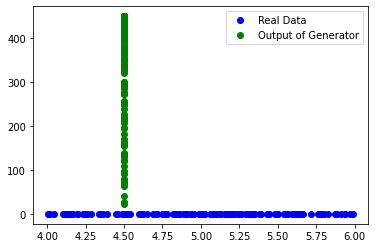

4520, gen_loss: 4.601397813530639e-05, disc_loss: 0.0003596334718167782
4540, gen_loss: 1.9430372049100697e-05, disc_loss: 0.00014232528337743133
4560, gen_loss: 3.5968321753898636e-05, disc_loss: 0.00016061494534369558
4580, gen_loss: 2.7242491341894493e-05, disc_loss: 0.0007847603410482407
4600, gen_loss: 4.402085687615909e-05, disc_loss: 0.00036321504740044475


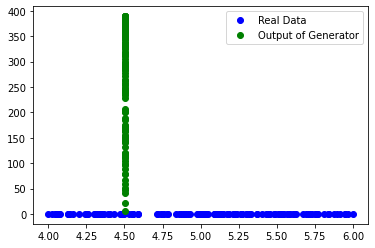

4620, gen_loss: 3.7509718822548166e-05, disc_loss: 0.000229759665671736
4640, gen_loss: 9.26122156670317e-05, disc_loss: 0.0005871995235793293
4660, gen_loss: 3.3435037039453164e-05, disc_loss: 0.00023161405988503247
4680, gen_loss: 2.5755127353477292e-05, disc_loss: 0.00026751431869342923
4700, gen_loss: 4.9892198148882017e-05, disc_loss: 0.00034890370443463326


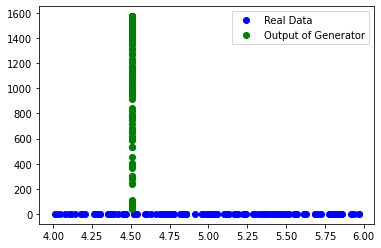

4720, gen_loss: 3.823617589659989e-05, disc_loss: 0.0003419860440772027
4740, gen_loss: 2.7911197321373038e-05, disc_loss: 0.00025789233040995896
4760, gen_loss: 4.1114079067483544e-05, disc_loss: 0.00040433325921185315
4780, gen_loss: 3.304294295958243e-05, disc_loss: 0.00029044406255707145
4800, gen_loss: 2.47660354943946e-05, disc_loss: 0.0001537837233627215


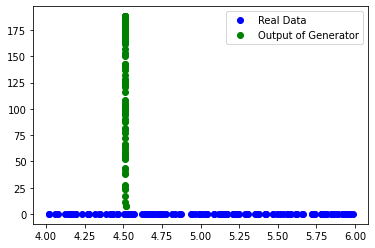

4820, gen_loss: 2.7141901227878407e-05, disc_loss: 0.00018025933241005987
4840, gen_loss: 5.218336809775792e-05, disc_loss: 0.0005523655563592911
4860, gen_loss: 3.506025313981809e-05, disc_loss: 0.00020446526468731463
4880, gen_loss: 3.660816582851112e-05, disc_loss: 0.0004361366154626012
4900, gen_loss: 2.9879140129196458e-05, disc_loss: 0.00040578277548775077


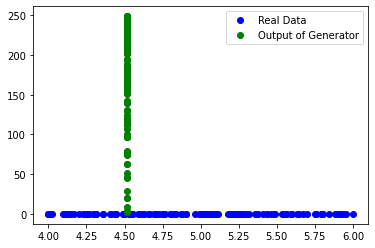

4920, gen_loss: 3.819612902589142e-05, disc_loss: 0.00030226452508941293
4940, gen_loss: 4.141956742387265e-05, disc_loss: 0.00030699980561621487
4960, gen_loss: 2.482471063558478e-05, disc_loss: 0.00027030770434066653
4980, gen_loss: 2.4535996999475174e-05, disc_loss: 0.0008092160569503903


In [ ]:
# Start the training and plot the distributions
training = GANTrainer(
    training_steps=5000,
    discriminator_epochs=10,
    batch_size=128,
    learning_rate=0.01,
    plot_graphs=True,
    plotting_interval=100)
training.train(x)